In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as stat
from tqdm import tqdm
from scipy.stats import permutation_test, pearsonr
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
plt.rcParams["figure.figsize"] = (7, 7)
sns.set_style('dark')

In [2]:
df = pd.read_csv('formatted_bike_data.csv', index_col=0)
df.head()

,duration,start_date,end_date,start_station_number,start_station,end_station_number,end_station,bike_number,member_type,day_of_week,days_since_jan1_2010,date,route,conditions_rain,conditions_snow,is_weekend,time_of_day_morning,time_of_day_night,time_of_day_noon,temp_regular
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,4th & M St SW,W00742,1,Monday,262,2010-09-20,M St & New Jersey Ave SE4th & M St SW,0,0,0,0,0,1,1
1,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,19th St & Pennsylvania Ave NW,W00993,1,Monday,262,2010-09-20,5th & K St NW19th St & Pennsylvania Ave NW,0,0,0,0,0,1,1
2,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,15th & P St NW,W00883,1,Monday,262,2010-09-20,19th St & Pennsylvania Ave NW15th & P St NW,0,0,0,0,0,1,1
3,982,2010-09-20 12:14:27,2010-09-20 12:30:50,31109,7th & T St NW,31200,Massachusetts Ave & Dupont Circle NW,W00850,1,Monday,262,2010-09-20,7th & T St NWMassachusetts Ave & Dupont Circle NW,0,0,0,0,0,1,1
4,1159,2010-09-20 12:26:08,2010-09-20 12:45:27,31603,1st & M St NE,31603,1st & M St NE,W01023,1,Monday,262,2010-09-20,1st & M St NE1st & M St NE,0,0,0,0,0,1,1


In [3]:
# Remove all the variables not needed for the model analysis.
reg_df = df.drop(['start_date', 'end_date','start_station', 'end_station', 'bike_number', 
                'date', 'day_of_week', 'start_station_number', 'end_station_number'], axis=1)

In [4]:
formula = 'duration ~ member_type + conditions_rain + conditions_snow + is_weekend + time_of_day_noon + time_of_day_morning + time_of_day_night + \
            time_of_day_morning * is_weekend + time_of_day_noon * is_weekend + time_of_day_night * is_weekend'

This is our OLS model specification, the interaction terms were determined a-priori since the grahps in the previous notebook indicate that there is an interaction effect with weekend and time of day. 

In [5]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Calculates the p-value by permuting the days since Jan 1st and calculating the correlation of the days since Jan1 with the OLS residuals.
    The null hypothesis is that there should be no correlation when permuting the days since and calculating the correlation with the residuals.
    """
    avg_correlation = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)  # Permutes the column.
        avg_correlation.append(np.corrcoef(resid, permutation)[1, 0])
    avg_correlation = np.array(avg_correlation)
    p_val = sum(np.abs(avg_correlation) > np.abs(
        np.corrcoef(resid, days_since)[1, 0])) / num_perm  # Checks if the real correlation is significantly different from the permuted one.
    return p_val


In [7]:
p_vals = []
model_resuls = []
number_observations = []

for route in tqdm(reg_df.route.unique()):
    # Getting the pandas dataframe into the right form for least squares.
    X = reg_df[reg_df['route'] == route]
    days_since = X['days_since_jan1_2010']
    y = X['duration']
    number_observations.append(len(X))

    # Running OLS
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    results = model.fit()

    # Collecting the results
    result = permutation_test((days_since, results.resid), statistic=pearsonr, n_resamples=7500, permutation_type='pairings')
    p_vals.append(result.pvalue[0])
    model_resuls.append(results)

100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


Smallest number of observations: 356
Average Number of Observations: 710.552


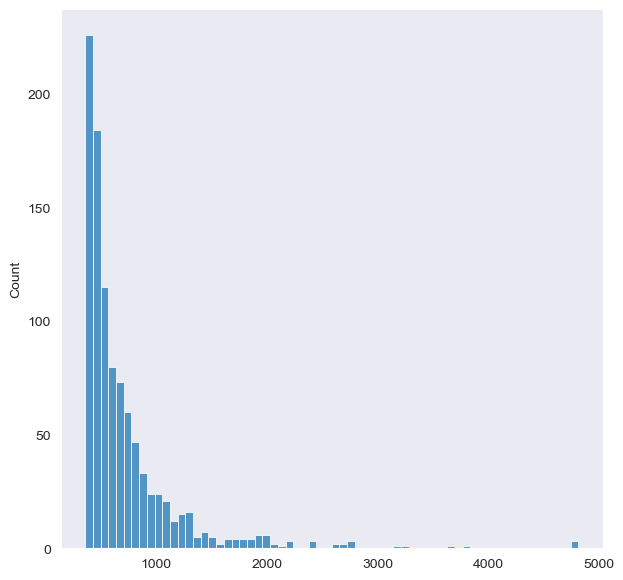

In [8]:
sns.histplot(number_observations)
print(f'Smallest number of observations: {min(number_observations)}')
print(f'Average Number of Observations: {np.mean(number_observations)}')

231 of unadjusted p-values are <= 0.05
0.231 of unadjusted p-values are <= 0.05


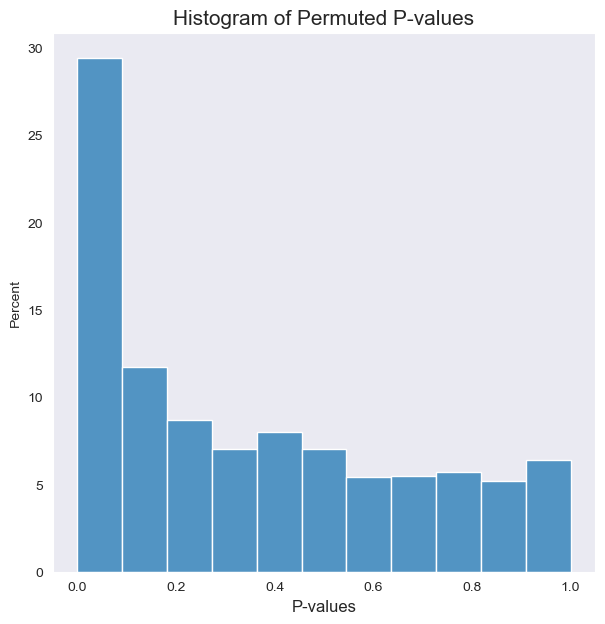

In [9]:
p = sns.histplot(p_vals, stat='percent')
p.set_xlabel('P-values', fontsize=12)
p.set_title('Histogram of Permuted P-values', fontsize=15)
print(f'{sum(np.array(p_vals) <= 0.05)} of unadjusted p-values are <= 0.05')
print(f'{sum(np.array(p_vals) <= 0.05) / len(p_vals)} of unadjusted p-values are <= 0.05')

Before correcting for false positives it would seem that 23% of the bike routes have a significant correlation. 

In [ ]:
reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_tsbh', returnsorted=False)
print('Number of rejections using two stage fdr correction (non-negative)', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_bh', returnsorted=False)
print('Number of rejections using BH', sum(reject_lst))
signif_pvals = np.where(corrected_pvals <= 0.05)[0]
significant_routes = np.random.randint(0,len(signif_pvals), size=6)

Number of rejections using two stage fdr correction (non-negative) 98
Number of rejections using BH 92


In [ ]:
# This code block will track the real correlation values (not the permuted ones) for plotting and analysis.
lst_real_corr = []
for route in tqdm(reg_df.route.unique()):
    # Formatting for OLS
    X = reg_df[reg_df['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']
    #OLS model
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    results = model.fit()
    # Collect results
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    lst_real_corr.append(real_corr)


100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


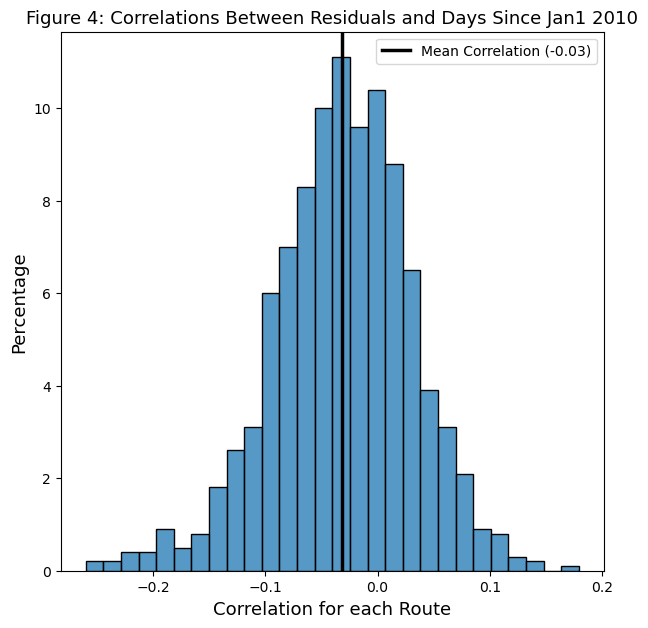

In [ ]:
sns.histplot(lst_real_corr)
plt.xlabel('Correlation for each Route', fontsize=13)
plt.ylabel('Percentage', fontsize=13)
plt.title('Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)
plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-',
            linewidth=2.5, label=f'Mean Correlation ({round(np.mean(lst_real_corr),2)})')
plt.legend();
# plt.savefig('fig4.png')

There is a mean correlation of -0.03 which is highly robust since we are averaging over many different samples. This means that bike rides became shorter from the start of the period to the end of the period. This is to be expected as urban planners have been increasing bike lanes and making biking more palatable for the average city dweller.

Further, the distribution has a left skew to it which means some routes had a very large decrease in time. This is likely due to a bridge being built or new roads accessing previously longer routes. 

In [ ]:
positive = 0
neg = 0
signif_pvals = np.where(corrected_pvals <= 0.05)[0]
for i in signif_pvals:
    if lst_real_corr[i] >= 0:
        positive += 1
    else:
        neg += 1

print(f'significant positive correlation {positive}')
print(f'significant negative correlation {neg}')
print(f"{100*round(neg/(neg+positive),2)}% of the significant correlations are in the negative direction.")


significant positive correlation 5
significant negative correlation 87
95.0% of the significant correlations are in the negative direction.


We can conclude that 86 routes had a significant decrease in bike ride time while 5 routes had an increase in ride duration. 

### This section focuses on 6 randomly selected bike routes for visual interpretation

In [ ]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Slightly Changing original function so it can plot residuals.
    """
    permutation_corr = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)
        permutation_corr.append(np.corrcoef(results.resid, permutation)[1, 0]) # The [1,0] indexing just grabs one of the correlation values in the matrix.
    permutation_corr = np.array(permutation_corr)
    p_val = sum(np.abs(permutation_corr) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm
    return p_val, permutation_corr

In [ ]:
significant_pvals_index = np.random.randint(0,len(signif_pvals), size=6)
significant_routes = signif_pvals[significant_pvals_index] # Chosen randomly. 
lst_real_corr = []
perm_corr = []
lst_residuals = []
lst_days_since = []
p_values_lst = []
model_results = []

# This loop is a very similar setup to the initial model creation.
for route_index in significant_routes: 
    # Creating individual dataframes for each Route.
    route = reg_df.route.unique()[route_index]
    X = reg_df[reg_df['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']

    # Running OLS.
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_jan1_2010']
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    X = sm.add_constant(X)

    # model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    p_val, corr_avg = permut_p_value(results.resid, days_since)

    # Collecting Results.
    lst_residuals.append(results.resid)
    lst_days_since.append(days_since)
    lst_real_corr.append(real_corr)
    p_values_lst.append(p_val)
    perm_corr.append(corr_avg)
    model_results.append(results)

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     14.18
Date:                Sun, 28 Aug 2022   Prob (F-statistic):           6.21e-23
Time:                        12:53:48   Log-Likelihood:                -4666.8
No. Observations:                 684   AIC:                             9356.
Df Residuals:                     673   BIC:                             9405.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

/Users/gabriel/miniforge3/envs/gabe/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     14.20
Date:                Sun, 28 Aug 2022   Prob (F-statistic):           1.03e-19
Time:                        12:53:51   Log-Likelihood:                -3321.4
No. Observations:                 380   AIC:                             6663.
Df Residuals:                     370   BIC:                             6702.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [ ]:
lst_std_resid = []
for result in model_results:
    lst_std_resid.append((result.resid - result.resid.mean()) / result.resid.std())

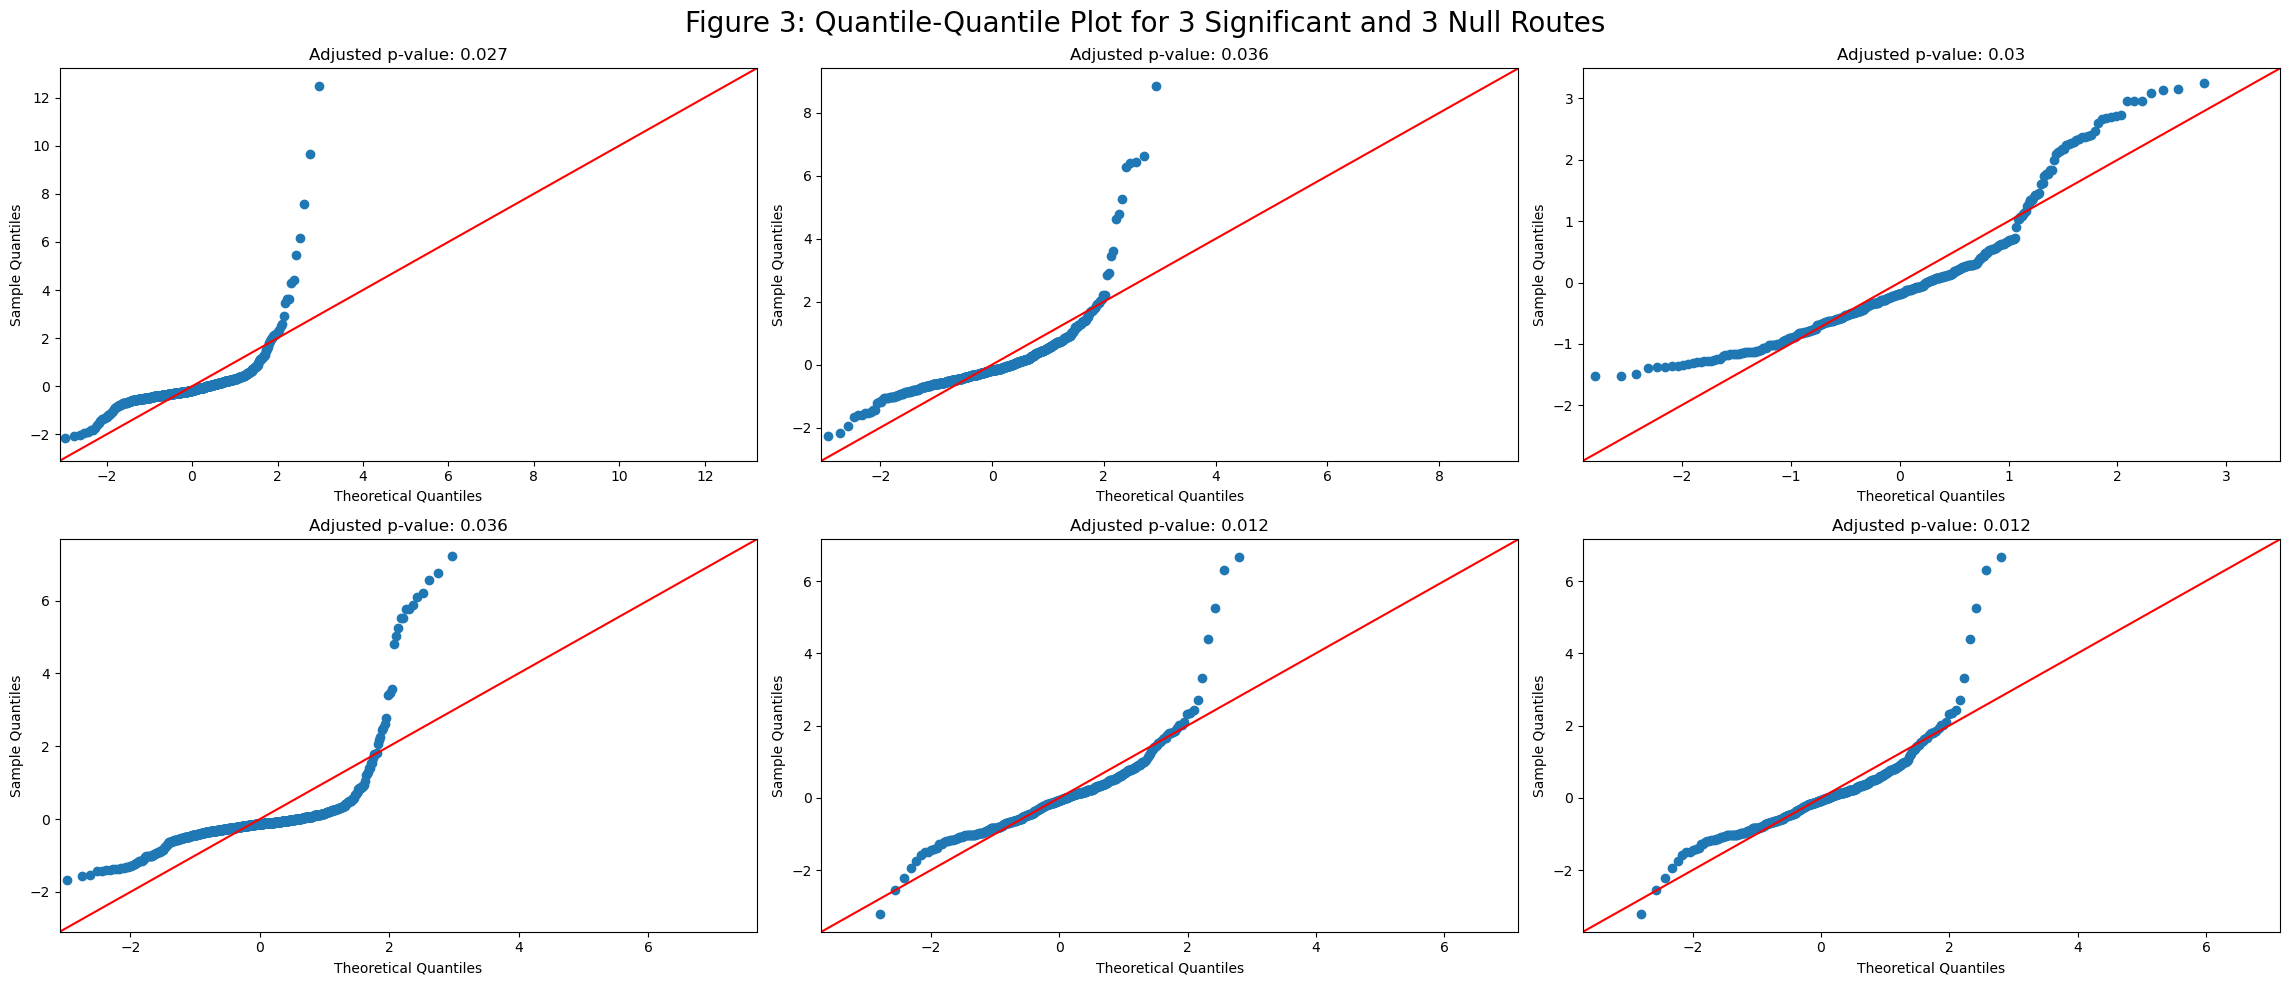

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))

p = sm.qqplot(data = lst_std_resid[0], ax = axes[0,0], line="45", )

axes[0, 0].set_title(f'Adjusted p-value: {round(corrected_pvals[significant_routes[0]],3)}')

p = sm.qqplot(lst_std_resid[1], ax = axes[0,1], line="45")
axes[0, 1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

p = sm.qqplot(lst_std_resid[2], ax = axes[0,2], line="45")
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

p = sm.qqplot(lst_std_resid[3], ax = axes[1,0], line="45")
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')

p = sm.qqplot(lst_std_resid[4], ax = axes[1,1], line="45")
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')

p = sm.qqplot(lst_std_resid[5], ax = axes[1,2], line="45")
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
    
plt.suptitle('Quantile-Quantile Plot for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()
plt.savefig('fig3.png')


The QQ-plots don't look good from an interpretable level but most of them are approximately on the line with ups and downs. For our use case the distribution of the resiudals don't matter since we are not interested in coefficient estimates but instead in the raw correlation with the residuals and time. If the residuals have a large right tail, than that will be information we would want to consider if its a function of time. 

In [ ]:
# Gathering residuals after grouping by "days since Jan 10th" for future plotting.

plot_resid = []
plot_days_since = []
for i in range(len(lst_residuals)):
    k = pd.DataFrame({'lst_residuals': lst_residuals[i], 'lst_days_since': lst_days_since[i]}).groupby(
        'lst_days_since')['lst_residuals'].mean()
    plot_days_since.append(k.index)
    plot_resid.append(k.values)

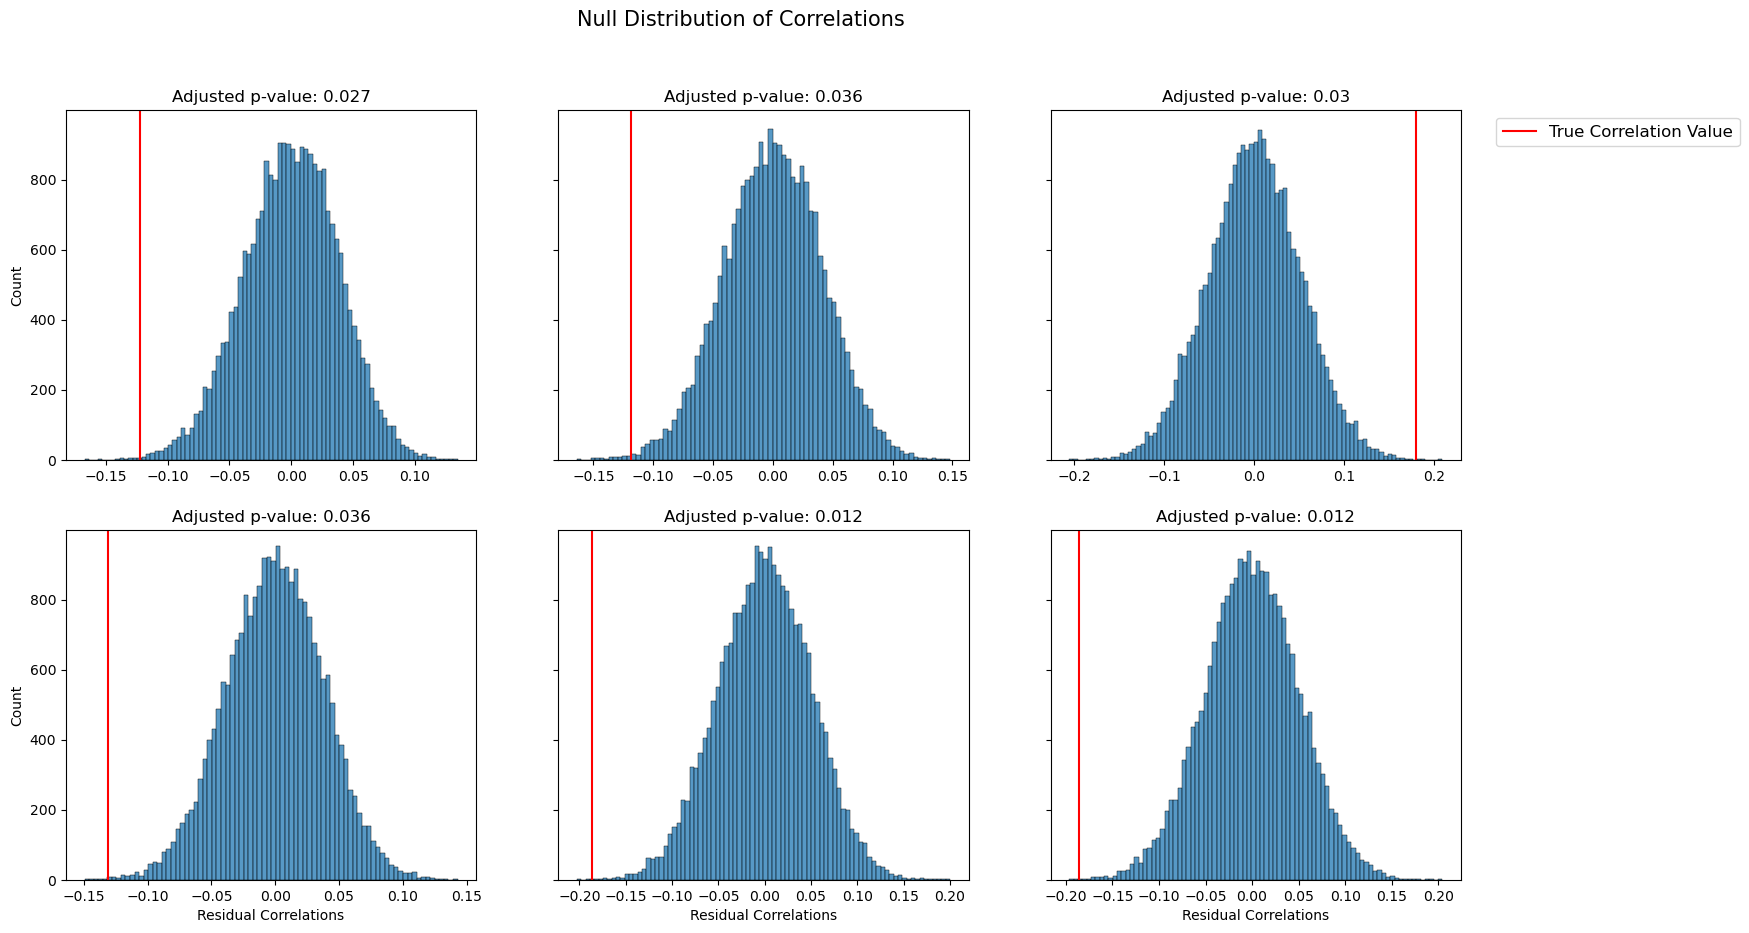

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

sns.histplot(ax=axes[0, 0], data=perm_corr[0], )
axes[0, 0].axvline(lst_real_corr[0], color='r')
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.histplot(ax=axes[0, 1], data=perm_corr[1], )
axes[0, 1].axvline(lst_real_corr[1], color='r', label='True Correlation Value')
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.histplot(ax=axes[0, 2], data=perm_corr[2], )
axes[0, 2].axvline(lst_real_corr[2], color='r', label='True Correlation Value')
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.histplot(ax=axes[1, 0], data=perm_corr[3], )
axes[1, 0].axvline(lst_real_corr[3], color='r')
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
axes[1, 0].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 1], data=perm_corr[4], )
axes[1, 1].axvline(lst_real_corr[4], color='r', label='True Correlation Value')
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
axes[1, 1].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 2], data=perm_corr[5], )
axes[1, 2].axvline(lst_real_corr[5], color='r', label='True Correlation Value')
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
axes[1, 2].set_xlabel('Residual Correlations')

plt.suptitle('Null Distribution of Correlations', fontsize=15)

axes[0, 2].legend(loc="upper right", bbox_to_anchor=(
    1.7, 1), prop={'size': 12})
# plt.savefig('fig7.png')


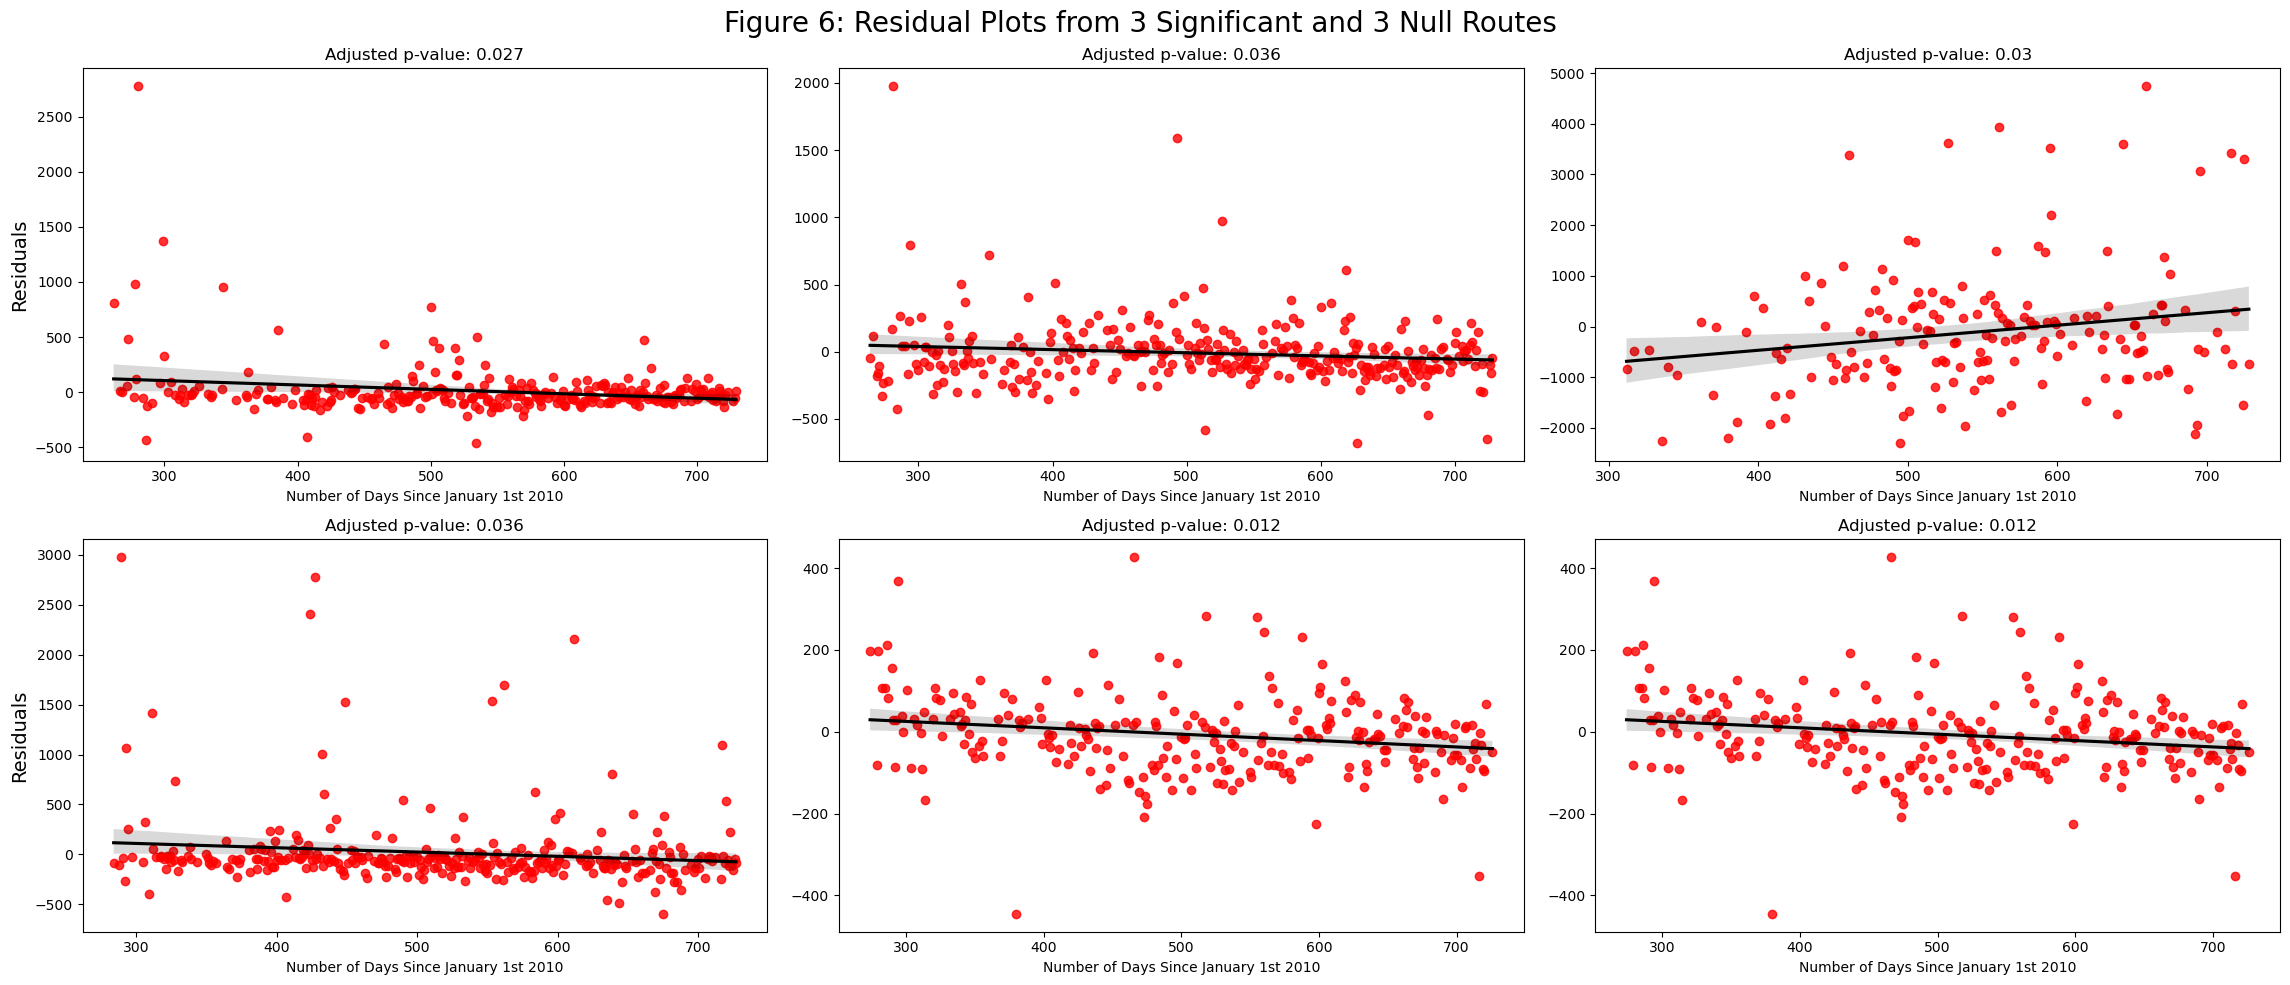

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10), sharex=True)
p = sns.regplot(ax=axes[0, 0], x=plot_days_since[0], y=plot_resid[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 1], x=plot_days_since[1], y=plot_resid[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=plot_days_since[2], y=plot_resid[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 0], x=plot_days_since[3], y=plot_resid[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 1], x=plot_days_since[4], y=plot_resid[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=plot_days_since[5], y=plot_resid[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')
plt.suptitle('Residual Plots from 3 Significant and 3 Null Routes ', fontsize=20)
plt.tight_layout(pad=-2)


In [ ]:
non_significant_routes = [200,100, 220]
duration = []
days_since = []
for i in non_significant_routes[:3]:
    route = reg_df.route.unique()[i]
    mask = reg_df[reg_df['route'] == route]
    days_since.append(mask['days_since_jan1_2010'])
    duration.append(mask['duration'])

for i in significant_routes[:3]:
    route = reg_df.route.unique()[i]
    mask = reg_df[reg_df['route'] == route]
    days_since.append(mask['days_since_jan1_2010'])
    duration.append(mask['duration'])

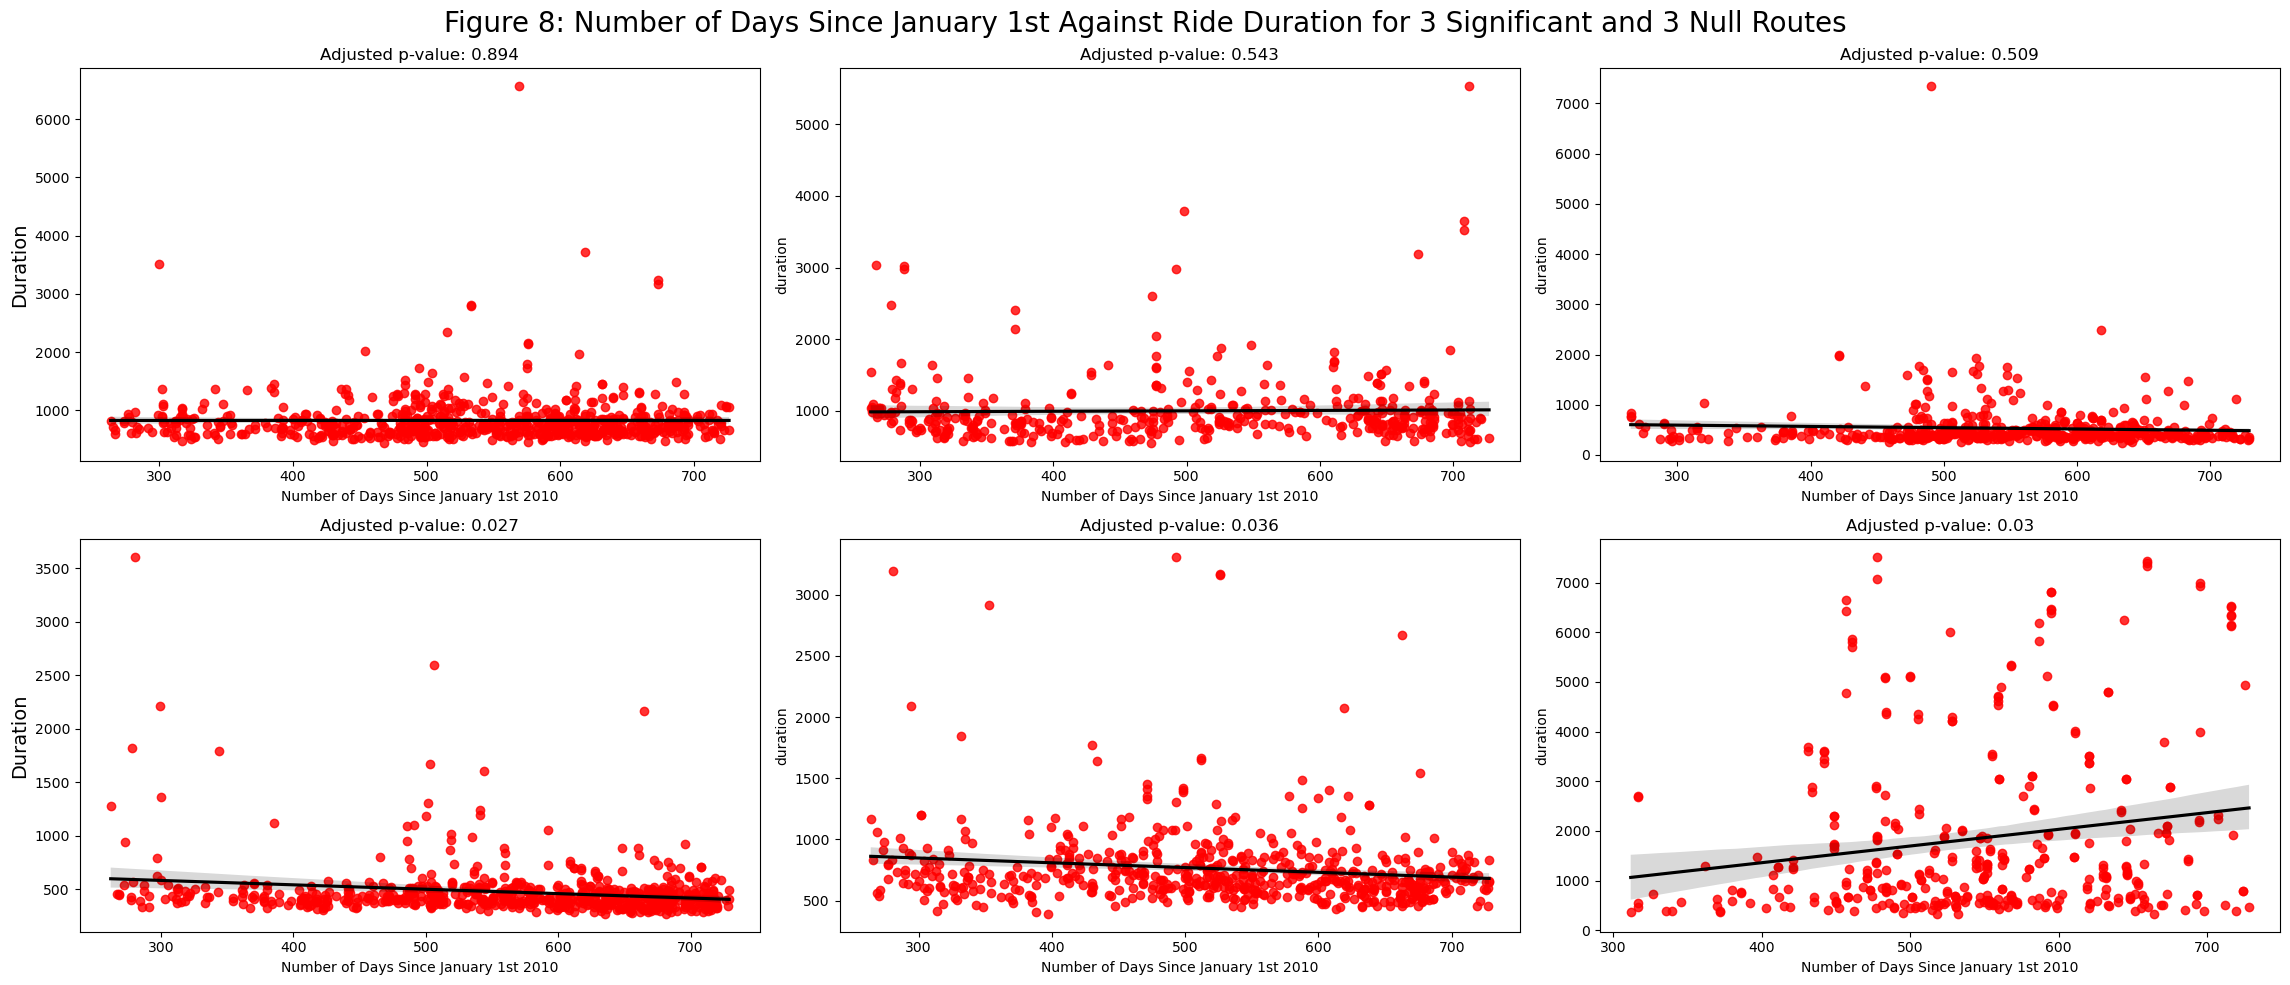

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10), sharex=True)
p = sns.regplot(ax=axes[0, 0], x=days_since[0], y=duration[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Duration', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[non_significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 1], x=days_since[1], y=duration[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[non_significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=days_since[2], y=duration[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[non_significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 0], x=days_since[3], y=duration[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_ylabel('Duration', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 1], x=days_since[4], y=duration[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=days_since[5], y=duration[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')
plt.suptitle('Number of Days Since January 1st Against Ride Duration for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout(pad=-2)


The difference in the correlation between duration and time is very subtle, but no doubt the slope of the line is different on the bottom three graphs compared to the top three.